In [1]:
# Importarea bibliotecilor necesare

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


In [3]:

# 1. Încărcarea setului de date
file_path = 'C:\\Users\\user\\Desktop\\ASEM\\ML\\lab2\\bank-full.xls'
try:
    data = pd.read_csv(file_path, sep=';')
    print("Date încărcate cu succes.")
except FileNotFoundError:
    raise FileNotFoundError("Fișierul specificat nu a fost găsit. Verifică calea corectă.")


Date încărcate cu succes.


In [4]:

# 2. Preprocesarea datelor

# a) Vizualizarea primelor 5 rânduri din setul de date
print("Primele 5 rânduri ale dataset-ului:")
print(data.head())

# b) Vizualizarea statisticilor descriptive
print("Statistici descriptive:")
print(data.describe())

# c) Tratarea valorilor lipsă
print("Numărul de valori lipsă per coloană:")
print(data.isnull().sum())
# Eliminăm valorile lipsă
data = data.dropna()

# d) Detectarea și eliminarea outlierilor folosind IQR
numeric_cols = data.select_dtypes(include=[np.number]).columns
Q1 = data[numeric_cols].quantile(0.25)
Q3 = data[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
data = data[~((data[numeric_cols] < (Q1 - 1.5 * IQR)) | (data[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]


Primele 5 rânduri ale dataset-ului:
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  
Statistici descriptive:
                age        balance           day   

Numărul de clustere identificate de DBSCAN: 1


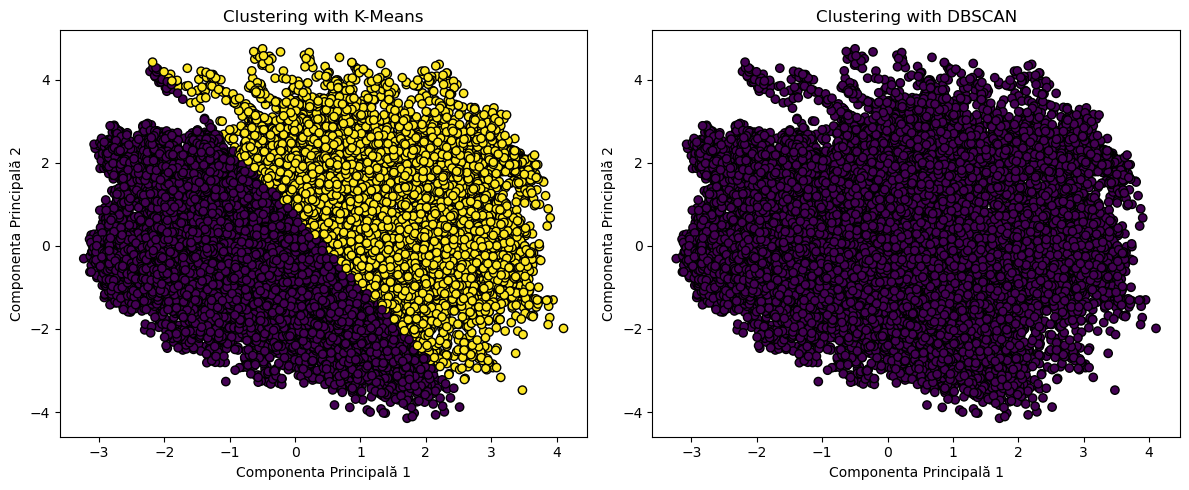

Rezultatele clustering-ului și rapoartele de clasificare au fost salvate în fișiere CSV.


In [5]:



# 2. Pregătirea datelor
X = data.drop('y', axis=1)
y = data['y']

# Transformarea variabilelor categoriale în variabile numerice
X = pd.get_dummies(X, drop_first=True)  # Convertim variabilele categoriale

# Conversia etichetelor adevărate 'y' în valori numerice
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # 'no' -> 0, 'yes' -> 1

# 3. Standardizarea datelor
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Reducerea dimensionalității folosind PCA
pca = PCA(n_components=2)  # Reducing to 2 dimensions for visualization
X_pca = pca.fit_transform(X_scaled)

# 5. Clustering folosind K-Means
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)

# 6. Clustering folosind DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=3)  # Ajustează eps și min_samples
dbscan_labels = dbscan.fit_predict(X_pca)

# Verificarea numărului de clustere identificate de DBSCAN
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)  # -1 este pentru zgomot
print(f'Numărul de clustere identificate de DBSCAN: {n_clusters_dbscan}')

# 7. Vizualizarea rezultatelor K-Means
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', marker='o', edgecolor='k')
plt.title('Clustering with K-Means')
plt.xlabel('Componenta Principală 1')
plt.ylabel('Componenta Principală 2')

# 8. Vizualizarea rezultatelor DBSCAN
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis', marker='o', edgecolor='k')
plt.title('Clustering with DBSCAN')
plt.xlabel('Componenta Principală 1')
plt.ylabel('Componenta Principală 2')

plt.tight_layout()
plt.show()

# 9. Pregătirea rezultatelor pentru salvare
results = {
    'Model': ['K-Means', 'DBSCAN'],
    'Labels': [kmeans_labels.tolist(), dbscan_labels.tolist()]
}

# Crearea unui DataFrame pentru a salva rezultatele
results_df = pd.DataFrame(results)

# 10. Salvarea rezultatelor într-un fișier CSV
results_df.to_csv('clustering_results.csv', index=False)

# 11. Afișarea rapoartelor de clasificare pentru K-Means
kmeans_report = classification_report(y_encoded, kmeans_labels, output_dict=True)

# Verificăm dacă DBSCAN a returnat etichete valide pentru a genera raportul
if len(set(dbscan_labels)) > 1:  # Asigură-te că există cel puțin 2 clustere
    dbscan_report = classification_report(y_encoded, dbscan_labels, output_dict=True)
else:
    dbscan_report = {'accuracy': 0.0, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0}}

# 12. Salvarea rapoartelor de clasificare într-un fișier CSV
classification_results = {
    'Model': ['K-Means', 'DBSCAN'],
    'Accuracy': [kmeans_report['accuracy'], dbscan_report['accuracy']],
    'Precision': [kmeans_report['1']['precision'], dbscan_report['1']['precision']],
    'Recall': [kmeans_report['1']['recall'], dbscan_report['1']['recall']],
    'F1-Score': [kmeans_report['1']['f1-score'], dbscan_report['1']['f1-score']]
}

classification_results_df = pd.DataFrame(classification_results)
classification_results_df.to_csv('classification_results.csv', index=False)

print("Rezultatele clustering-ului și rapoartele de clasificare au fost salvate în fișiere CSV.")
